# Content-Aware Image Retargeting
Reduce the width of images (`Baby.png`, `Diana.png`, `Snowman.png`) by `seams_number` columns using Seam Carving, implemented from scratch. Optionally use depth/saliency maps or other energy functions. Visualize seams if enabled.

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [47]:
def edgeness(img):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gr_x = cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0, ksize=3)
    gr_y = cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1, ksize=3)
    edge_map = cv2.magnitude(gr_x, gr_y)
    edge_map_8u = cv2.convertScaleAbs(edge_map)
    return edge_map_8u

def seam_carving(image, seams_number, depth_map=None, saliency_map=None, visualize=False):
    final_img = np.copy(image)
    seam_energies = []

    if visualize:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.axis('off')

    if (depth_map is None) and (saliency_map is None):
        energy_map = edgeness(final_img)
    elif saliency_map is not None:
        energy_map = saliency_map.astype(np.float64)
    else:
        energy_map = depth_map.astype(np.float64)

    for i in range(seams_number):
        h, w = energy_map.shape
        if w <= 1:
            break

        dp = np.copy(energy_map)
        for r in range(1, h):
            dp[r, 0] += min(dp[r - 1, 0], dp[r - 1, 1])
            for c in range(1, w - 1):
                dp[r, c] += min(dp[r - 1, c - 1], dp[r - 1, c], dp[r - 1, c + 1])
            dp[r, w - 1] += min(dp[r - 1, w - 2], dp[r - 1, w - 1])
        
        seam = np.zeros(h, dtype=int)
        seam[-1] = np.argmin(dp[-1, :])
        
        seam_energies.append(dp[-1, seam[-1]])

        for r in range(h - 2, -1, -1):
            prev_c = seam[r + 1]
            if prev_c == 0:
                seam[r] = np.argmin(dp[r, 0:2])
            elif prev_c == w - 1:
                seam[r] = np.argmin(dp[r, w - 2:w]) + (w - 2)
            else:
                seam[r] = np.argmin(dp[r, prev_c - 1:prev_c + 2]) + (prev_c - 1)

        if visualize:
            clear_output(wait=True)
            vis_img_with_seam = np.copy(final_img)
            for r, c in enumerate(seam):
                vis_img_with_seam[r, c] = [0, 0, 1] 

            ax.imshow(cv2.cvtColor((vis_img_with_seam * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
            display(fig)

        h_img, w_img, c_img = final_img.shape
        new_img = np.zeros((h_img, w_img - 1, c_img), dtype=final_img.dtype)
        new_map = np.zeros((h, w - 1), dtype=energy_map.dtype)

        for r in range(h):
            seam_col = seam[r]
            mask = np.ones(w, dtype=bool)
            mask[seam_col] = False
            new_img[r] = final_img[r, mask]
            new_map[r] = energy_map[r, mask]

        final_img = new_img
        energy_map = new_map

    if visualize:
        clear_output(wait=True)
        ax.imshow(cv2.cvtColor((final_img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax.set_title(f'Baby resized')
        display(fig)
        plt.close(fig)

    return final_img, seam_energies


In [48]:
baby_path = 'Snowman.png'
baby_dmap_path = 'Snowman_DMap.png'
baby_smap_path = 'Snowman_SMap.png'

baby = cv2.imread(baby_path).astype(np.float32) / 255.0
baby_dmap = cv2.imread(baby_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
baby_smap = cv2.imread(baby_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

seams_number = 200
visualize = False

اگر فلگ درست باشد، به دلیل رندرینگ تصویر، فرآیند زمان قابل توجهی بیشتر به طول می انجامد. 

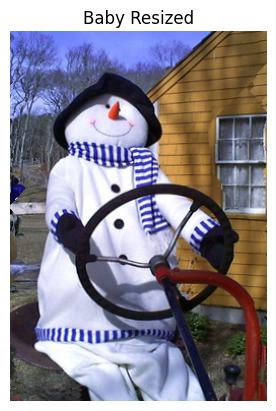

True

In [49]:


baby_resized, baby_energies = seam_carving(baby, seams_number, baby_dmap, baby_smap, visualize)

with open('seam_energy_log.txt', 'w') as f:
    f.write('Baby Seam Energies:\n' + '\n'.join(map(str, baby_energies)) + '\n')

if not visualize:
    plt.imshow(cv2.cvtColor(baby_resized, cv2.COLOR_BGR2RGB))
    plt.title('Baby Resized')
    plt.axis('off')
    plt.show()
cv2.imwrite('Baby_resized.png', (baby_resized * 255).astype(np.uint8))
